# Simulation Optimsiation using DES model of homeless response system

In [1]:
import datetime
print('Current version of this notebook updated ' + str(datetime.date.today()))

Current version of this notebook updated 2023-11-08


## Ranking & Selection

First we employ a Ranking & Selection algorithm based on the Kim & Nelson procedure. Details of this procedure can be found in section 9.3.2 (page 247) of 'Foundation and Methods of Stochastic Simulation' - Edition 2 (2021). The Python code for this procedure is found in the ranking_and_selection.py file in the GitHub repository. Below we import this module, and some others

In [2]:
# modules from this repository
import ranking_and_selection as rs
import simulation_model as sim
import queueing_model as qm

# external packages
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import json

### Testing using Inventory System

In order to test our KN procedure, we test it on a simulation model which has already been analysed using the KN algorithm in STOR-606 module - this is an $(s,S)$ inventory system where stock is replenished to a level of $S$ when it reaches $s$. 

In [3]:
solutions = [i for i in range(1600)]
k=np.array([i for i in range(1600)])

def simulate(solution):
    # one replication of simulating the cost of the inventory policy
    out=rs.InventorySystem(solution)[0]
    return out

In [4]:
random.seed(1)
opt_sols = []
for i in range(0):
    spc = rs.SolutionSpace(solutions)
    spc.optimise_rs(0.05, 50, 1, simulate, False, False)
    s,S = rs.get_sS_system(k[spc.active][0])
    opt_sols.append((s,S))

In [5]:
print('(s,S) for the optimal solution found at each iteration of the algorithm')
print(opt_sols)

(s,S) for the optimal solution found at each iteration of the algorithm
[]


The above illustrates that this KN algorithm can return different solutions when it is run at different times (i.e. with different starting seeds) - this is likely due to the difference between the true best and other good solutions being less than the 'delta' indiffference zone parameter used when running the algorithm above. 

In [6]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

### Developing a discrete solution space for the homeless response system

In [7]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 120, 'shelter' : 120}
costs = {'housing': 1, 'shelter': 1}
build_rate_length_years = 6

# generate solution space
sols = rs.generate_solution_space(build_rate_options, 
                                  annual_budget, 
                                  accommodation_budgets, 
                                  costs, 
                                  build_rate_length_years)

sols = rs.keep_max_budget(sols, costs, annual_budget)

Below we initialise a solution space object with the solutions we have generated

In [8]:
spc = rs.SolutionSpace(sols)

### Analytic treatment of the solution space

In [9]:
# model analytically
outputs = []
for s in range(len(sols)):
    # create instance of queue
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])

    q.model_dynamics(data_as_is['analysis_horizon'],
                     data_as_is_analytical['delta_t'])
    outputs.append(q.num_unsheltered_avg)

done 0 at time 2023-11-07 18:46:07.133482
done 1 at time 2023-11-07 18:46:12.389463
done 2 at time 2023-11-07 18:46:17.618471
done 3 at time 2023-11-07 18:46:22.842074
done 4 at time 2023-11-07 18:46:28.211226
done 5 at time 2023-11-07 18:46:33.433697
done 6 at time 2023-11-07 18:46:38.592188
done 7 at time 2023-11-07 18:46:43.827334
done 8 at time 2023-11-07 18:46:48.935644
done 9 at time 2023-11-07 18:46:54.116429
done 10 at time 2023-11-07 18:46:59.293571
done 11 at time 2023-11-07 18:47:04.614901
done 12 at time 2023-11-07 18:47:09.848530
done 13 at time 2023-11-07 18:47:15.165161
done 14 at time 2023-11-07 18:47:20.450826
done 15 at time 2023-11-07 18:47:25.629659
done 16 at time 2023-11-07 18:47:30.930203
done 17 at time 2023-11-07 18:47:35.968698
done 18 at time 2023-11-07 18:47:41.236278
done 19 at time 2023-11-07 18:47:46.418790
done 20 at time 2023-11-07 18:47:51.641424
done 21 at time 2023-11-07 18:47:56.746655
done 22 at time 2023-11-07 18:48:02.033447
done 23 at time 2023-

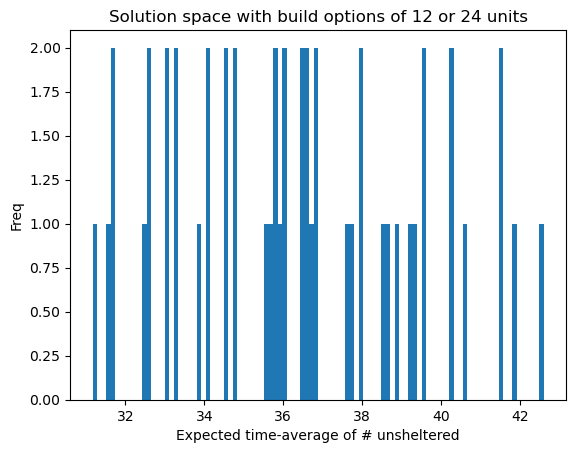

In [10]:
# Creating histogram 
fig, ax = plt.subplots(1, 1) 
ax.hist(outputs, 100) 
  
# Set title 
ax.set_title("Solution space with build options of 12 or 24 units") 
    
# adding labels 
ax.set_xlabel('Expected time-average of # unsheltered') 
ax.set_ylabel('Freq') 

plt.show()

In [11]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    my_dict[6] = " "
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+7] = element
    my_dict[13] = outputs[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'c']

In [17]:
# Looking at the improvements in the objective func given by a change in each dimension separately
low_val = 12
dims_all = ['h1','h2','h3','h4','h5','h6','sh1','sh2','sh3','sh4','sh5','sh6']
list_imprv = [] # data on improvements
for dim in dims_all:
    for i in df_analytic[df_analytic[dim]==low_val].index.tolist():
        value_base = df_analytic.iloc[i]['c']
        conditions = dim + '''!=''' + str(low_val)
        for dim_compare in [dims_all[j] for j in range(len(dims_all)) if dims_all[j]!=dim]:
            conditions = conditions + ''' & ''' + dim_compare + '==' + str(df_analytic.iloc[i][dim_compare])
        df_analytic_with_conditions = df_analytic.query(conditions).reset_index(drop=True)
        if len(df_analytic_with_conditions) > 0:
            value_improve = df_analytic_with_conditions['c'][0]
            improvement = value_base - value_improve
            improvement = {'dim': dim,
                           'imprv': improvement}
            list_imprv.append(improvement)
        
df_imprv = pd.DataFrame.from_dict(list_imprv)

In [18]:
# This will only work if we don't restrict the solution space to solutions where the budget is maxed out. 
#df_imprv_summary = df_imprv.groupby('dim').mean().reset_index()
#df_imprv_summary

Above we see that building housing early is the most favourable option given this setup - this makes intuitive sense given this set up because there is no difference in cost built in to favour one accommodation type over the other. Extra housing has the ability to begin service time for someone in shelter and also take someone out of the unsheltered queue and into shelter. Extra shelter only has the ability to do the latter. We might in future consider a service time in housing which is dependent on the time spent in shelter - because we might consider time in shelter as 'partial service'. 

Furthermore - it is also intuitive that building more housing or shelter units the earlier the better is most favourable - since this setup favours improvements to the unsheltered queue equally at all times, and early builds have an effect over a longer period of time. 

In [19]:
# Look at the difference between true best and true second-best 
df_analytic_sorted = df_analytic.sort_values('c').reset_index(drop=True)
indiff = df_analytic_sorted.iloc[1, df_analytic_sorted.columns.get_loc('c')] - df_analytic_sorted.iloc[0, df_analytic_sorted.columns.get_loc('c')]

### Sim Opt treatment of solution space

We next set a seed and then look for an optimal solution using the KN algorithm. A line of text is printed below whenever solutions are removed from the candidate list by the algorithm. We use the true difference between best and second-best solutions as the indifference zone parameter, and we use an alpha of 0.05 - leading to a lower bound of 95% confidence in what we find. 

In [21]:
random.seed(1)
spc.optimise_rs(0.05, 
                100, 
                indiff, 
                sim.simulate_as_is, 
                True, 
                False, 
                data_as_is = data_as_is, 
                data_as_is_simulation = data_as_is_simulation)

starting routine at time  2023-11-07 18:57:05.510561
done init reps at time  2023-11-07 19:03:32.898256
start iteration 207 with 49 active solutions out of initial 50 at time 2023-11-07 19:10:25.743019
start iteration 222 with 48 active solutions out of initial 50 at time 2023-11-07 19:11:23.556462
start iteration 230 with 47 active solutions out of initial 50 at time 2023-11-07 19:11:53.344428
start iteration 234 with 46 active solutions out of initial 50 at time 2023-11-07 19:12:08.145380
start iteration 237 with 45 active solutions out of initial 50 at time 2023-11-07 19:12:18.999047
start iteration 238 with 44 active solutions out of initial 50 at time 2023-11-07 19:12:22.540994
start iteration 256 with 43 active solutions out of initial 50 at time 2023-11-07 19:13:24.270762
start iteration 259 with 42 active solutions out of initial 50 at time 2023-11-07 19:13:34.334170
start iteration 265 with 41 active solutions out of initial 50 at time 2023-11-07 19:13:53.933817
start iteratio

The details of the optimal solution are given below, followed by the following 20 solutions in decreasing order of the iteration number at which the KN algorithm removed them from the candidate list. 

In [22]:
# create dataframe of sim opt results
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+6] = element
    my_dict[12] = spc.eliminate[i]
    my_dict[13] = np.mean(spc.costs[i])
    my_dict[14] = np.var(spc.costs[i])
    my_list.append(my_dict)
df_sim = pd.DataFrame.from_dict(my_list)
df_sim.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'sh6', 'iter_elim', 'sim_mean', 'sim_var']

We now reset the seed and repeatedly optimise with the same indifference-zone parameter, but now with alpha = 0.25 - we should see that at least 25% of the optimal solutions found are not the true best. 

In [22]:
random.seed(5)
initial_reps = 5
spc = rs.SolutionSpace(sols)
spc.run_initial_reps(initial_reps,
                     sim.simulate_as_is,
                     data_as_is = data_as_is, 
                     data_as_is_simulation = data_as_is_simulation)
optim_sols = []
for i in range(500):
    spc.optimise_rs(0.5, 
                    initial_reps, 
                    indiff, 
                    sim.simulate_as_is, 
                    False, 
                    False, 
                    data_as_is = data_as_is, 
                    data_as_is_simulation = data_as_is_simulation)
    optim_sols.append(np.array(spc.solutions)[spc.active][0].solution)
    print('done ' + str(i) + str(np.array(spc.solutions)[spc.active][0].solution) + ' at time ' + str(datetime.datetime.now()))

done 0{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 20:34:07.561040
done 1{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 21:17:49.065458
done 2{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 21:55:30.861003
done 3{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 22:39:16.841792
done 4{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 23:13:58.716171
done 5{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-07 23:48:59.421368
done 6{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-08 00:22:20.604175
done 7{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 24, 24]} at time 2023-11-08 00:55:17.685635
done 8{'housing': [24, 24, 24, 24, 12, 12], 'shelter': [12, 12, 12, 12, 

KeyboardInterrupt: 

### Analysis of analytic and Sim Opt outputs

Here we order the solutions based on their analytical objective function value - and compare the results to the results of the KN Sim Opt routine (first results from using alpha = 0.05 and running the algorithm once. 'iter_elim' is the iteration of the algorithm where the solution was eliminated, 0 when this solution was never eliminated - i.e. the optimal. 'c' is the analytical cost (i.e. expectation of the time average of the size of the unsheltered queue). 

In [23]:
df_concat = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True).merge(df_sim, on = ['h1', 'h2', 'h3', 'h4', 'h5', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5'])
df_concat.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

NameError: name 'df_sim' is not defined

Above we see that the Sim Opt algorithm (KN) agrees with the analytic resuls that building housing early is the most favourable option given this setup. 

### A new solution space with shelter cheaper than housing

There are clearly some real-world benefits to building shelter rather than housing which we should to some extent incorporate into the model. Two benefits might include: 

* shelter is cheaper to build than housing
* shelter is quicker to build than housing. 

Firstly, we address the first bullet here and make shelter 0.5 times the price of housing. We achieve this by allowing double the number of shelter to be built, and changing the cost of the shelter, and keeping the annual budget the same. 

In [16]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [24, 48]}
annual_budget = 36
accommodation_budgets = {'housing' : 84, 'shelter' : 168}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
sols_cheap_shelter = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)
sols_cheap_shelter = rs.keep_max_budget(sols_cheap_shelter, costs, annual_budget)

In [17]:
# model analytically
outputs_cheap_shelter = []
for s in range(len(sols_cheap_shelter)):
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_cheap_shelter[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_cheap_shelter.append(q.num_unsheltered_avg)

In [19]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter[i]['housing']):
        my_dict[index] = element
    my_dict[build_rate_length_years] = " "
    for index, element in enumerate(sols_cheap_shelter[i]['shelter']):
        my_dict[index+build_rate_length_years + 1] = element
    my_dict[build_rate_length_years*2 + 1] = outputs_cheap_shelter[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
df_analytic.head(n=10).style.apply(lambda x: ["background: pink" if v == 48 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,,sh1,sh2,sh3,sh4,c
0,12,12,12,24,,48,48,48,24,15.296606
1,12,12,24,12,,48,48,24,48,15.571613
2,12,12,24,24,,48,48,24,24,15.599233
3,12,24,12,12,,48,24,48,48,17.418341
4,12,24,12,24,,48,24,48,24,17.436595
5,12,24,24,12,,48,24,24,48,18.097754
6,12,24,24,24,,48,24,24,24,18.171364
7,24,12,12,12,,24,48,48,48,19.532380
8,24,12,12,24,,24,48,48,24,19.544187
9,24,12,24,12,,24,48,24,48,20.069642


### A new solution space with shelter cheaper than housing and allowing zero shelter or zero housing to be built. 

In [20]:
# solution space constraints
build_rate_options = {'housing' : [0, 9, 18], 'shelter' : [0, 18, 36]}
annual_budget = 18
accommodation_budgets = {'housing' : 54, 'shelter' : 108}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
sols_cheap_shelter_inc_zero = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, costs, build_rate_length_years)
sols_cheap_shelter_inc_zero = rs.keep_max_budget(sols_cheap_shelter_inc_zero, costs, annual_budget)

In [21]:
# model analytically
outputs_cheap_shelter_inc_zero = []
for s in range(len(sols_cheap_shelter_inc_zero)):
    q = qm.queue(data_as_is['arrival_rates'], 
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_cheap_shelter_inc_zero[s], 
                 data_as_is['initial_demand'], 
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_cheap_shelter_inc_zero.append(q.num_unsheltered_avg)

In [22]:
# Dataframe of analytic results
my_list = []
for i in range(len(sols_cheap_shelter_inc_zero)):
    my_dict = {}
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['housing']):
        my_dict[index] = element
    my_dict[build_rate_length_years] = " "
    for index, element in enumerate(sols_cheap_shelter_inc_zero[i]['shelter']):
        my_dict[index+build_rate_length_years+1] = element
    my_dict[build_rate_length_years*2 +1] = outputs_cheap_shelter_inc_zero[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'c']

df_analytic = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True)
df_analytic.head(n=10).style.apply(lambda x: ["background: pink" if v == 36 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,,sh1,sh2,sh3,sh4,c
0,0,0,0,18,,36,36,36,0,59.591898
1,0,0,9,9,,36,36,18,18,63.096220
2,0,0,18,0,,36,36,0,36,63.241260
3,0,0,9,18,,36,36,18,0,63.681442
4,0,0,18,9,,36,36,0,18,64.560241
5,0,0,18,18,,36,36,0,0,65.145462
6,0,9,0,9,,36,18,36,18,65.506892
7,0,18,0,0,,36,0,36,36,65.813002
8,0,9,0,18,,36,18,36,0,66.092114
9,0,18,0,9,,36,0,36,18,67.131982


This indicates that given the new current set up - with cheaper shelter - shelter is always preferred over housing and even given the option of building a mix of shelter and housing, we would always opt for building no housing and all the shelter we can afford in this set up. 

### Exploring a range of different 'housing proportions'

In the previous example we looked at three different options each year: 

* 100\% housing
* 100\% shelter
* 1/3 housing, 2/3 shelter. 

The analytical results indicate (given current set up) that 100\% housing is preferred. We now want to look at a wider range of proportions for housing. 

We below develop a relatively small solution space, but covering a wider range of housing proportions. 

In [28]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 72, 'shelter' : 72}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# geneate solution space
num_build_points = round(data_as_is['time_btwn_changes_in_build_rate']/data_as_is['time_btwn_building'])
house_builds = [i for i in range(int(annual_budget/num_build_points)+1)] # every two months
sols_range = []

for n in house_builds: 
    new_sol = {'housing':[0 for i in range(build_rate_length_years)], 'shelter':[0 for i in range(build_rate_length_years)]}
    for i in range(build_rate_length_years):
        new_sol['housing'][i] = int(n*num_build_points)
        new_sol['shelter'][i] = int((annual_budget - (n*num_build_points))*(1/costs['shelter']))
    sols_range.append(new_sol)

In [29]:
sols_range

[{'housing': [0, 0, 0, 0], 'shelter': [72, 72, 72, 72]},
 {'housing': [6, 6, 6, 6], 'shelter': [60, 60, 60, 60]},
 {'housing': [12, 12, 12, 12], 'shelter': [48, 48, 48, 48]},
 {'housing': [18, 18, 18, 18], 'shelter': [36, 36, 36, 36]},
 {'housing': [24, 24, 24, 24], 'shelter': [24, 24, 24, 24]},
 {'housing': [30, 30, 30, 30], 'shelter': [12, 12, 12, 12]},
 {'housing': [36, 36, 36, 36], 'shelter': [0, 0, 0, 0]}]

In [32]:
# model analytically
outputs_range_unsh = []
outputs_range_sh = []
for s in range(len(sols_range)):
    q = qm.queue([i+20 for i in data_as_is['arrival_rates']], # increase demand so Q doesn't clear
                 data_as_is['service_mean'], 
                 data_as_is['initial_capacity'], 
                 sols_range[s], 
                 data_as_is['initial_demand'] + 60, # increase demand so Q doesn't clear
                 data_as_is_analytical['max_in_system'],
                 data_as_is['time_btwn_changes_in_build_rate'],
                 data_as_is['time_btwn_building'])
    q.model_dynamics(build_rate_length_years,
                     data_as_is_analytical['delta_t'])
    outputs_range_unsh.append(q.num_unsheltered_avg)
    outputs_range_sh.append(q.num_sheltered_avg)

#### Cost function: linear with # unsheltered

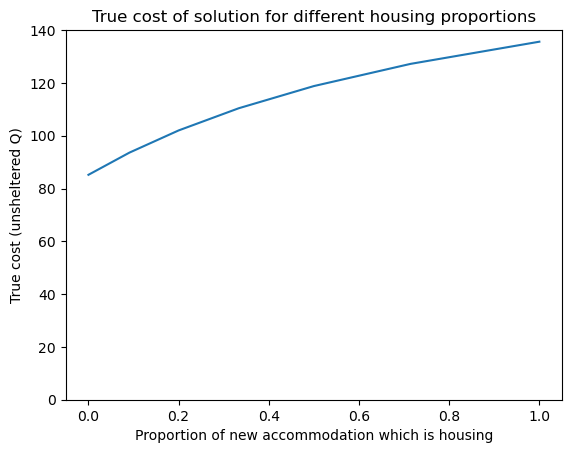

In [37]:
# Plot analytical results
# setup
fig = plt.figure()
ax = plt.axes()

# plot
x=[sols_range[i]['housing'][0]/(sols_range[i]['housing'][0] + sols_range[i]['shelter'][0]) for i in range(len(sols_range))]
ax.plot(x, outputs_range)

# axes
plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost (unsheltered Q)') 

plt.show()

#### Cost function: quadratic with # unsheltered and # sheltered

In [38]:
def cost_function(sh,unsh):
    cost = 0.5*(sh**2)+(unsh**2)
    return cost

costs = []
for i in range(len(sols_range)):
    costs.append(cost_function(outputs_range_sh[i],outputs_range_unsh[i]))

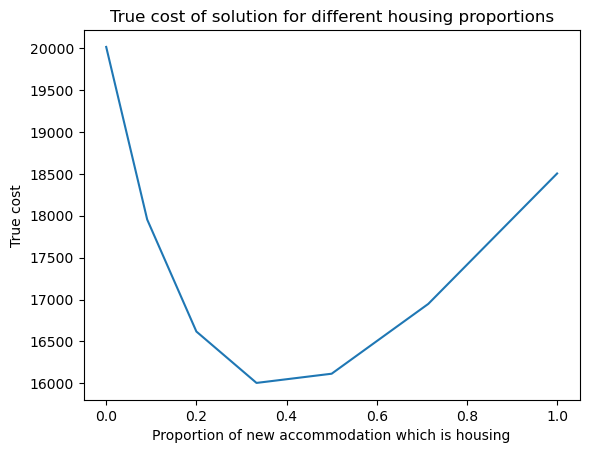

In [39]:
# setup
fig = plt.figure()
ax = plt.axes()

# plot
ax.plot(x, costs)

# axes
#plt.ylim([0, 140])

# Set title 
ax.set_title("True cost of solution for different housing proportions") 
    
# adding labels 
ax.set_xlabel('Proportion of new accommodation which is housing') 
ax.set_ylabel('True cost') 

plt.show()

#### Exploring the effect of changing both the cost of shelter and the service time at housing

In [1]:
import ranking_and_selection as rs
import queueing_model as qm
import json
import datetime

In [11]:
# Opening JSON file
with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_simulation.json') as json_file:
    data_as_is_simulation = json.load(json_file)
    
# Opening JSON file
with open('data_as_is_analytical.json') as json_file:
    data_as_is_analytical = json.load(json_file)

In [3]:
def obj_function(sh,unsh):
    obj_value = unsh
    return obj_value

In [4]:
# Explore range of shelter costs and service time distributions
print('start at time ' + str(datetime.datetime.now()))
additional_shelter = [i for i in range(12)]
service_times = [(i*0.5) for i in range(1,13)]
results = [[] for i in range(len(additional_shelter))]
sol_spaces = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    for j in range(len(service_times)):
        sols = rs.generate_solution_space_generic(additional_shelter[i], 4, 36)
        sol_spaces[i].append(rs.SolutionSpace(sols))
        sol_spaces[i][j].model_analytically(data_as_is, data_as_is_analytical, 4, service_times[j])
        sol_spaces[i][j].find_true_best(obj_function, 'linear_unsh')
        results[i].append(sum(sols[sol_spaces[i][j].true_best['linear_unsh'][0]]['housing'][0:3]))
        print('done (' + str(i) + ', ' + str(j) + ')' + ' at time ' + str(datetime.datetime.now()))

start at time 2023-11-09 12:33:48.573800
done (0, 0) at time 2023-11-09 12:34:36.654820
done (0, 1) at time 2023-11-09 12:35:24.943817
done (0, 2) at time 2023-11-09 12:36:12.684685
done (0, 3) at time 2023-11-09 12:36:59.911444
done (0, 4) at time 2023-11-09 12:37:47.296784
done (0, 5) at time 2023-11-09 12:38:34.382399
done (0, 6) at time 2023-11-09 12:39:21.462161
done (0, 7) at time 2023-11-09 12:40:08.219160
done (0, 8) at time 2023-11-09 12:40:55.291496
done (0, 9) at time 2023-11-09 12:41:42.221995
done (0, 10) at time 2023-11-09 12:42:29.559150
done (0, 11) at time 2023-11-09 12:43:16.577020
done (1, 0) at time 2023-11-09 12:44:03.460068
done (1, 1) at time 2023-11-09 12:44:50.291897
done (1, 2) at time 2023-11-09 12:45:37.761200
done (1, 3) at time 2023-11-09 12:46:25.175864
done (1, 4) at time 2023-11-09 12:47:12.299725
done (1, 5) at time 2023-11-09 12:47:59.235753
done (1, 6) at time 2023-11-09 12:48:46.187144
done (1, 7) at time 2023-11-09 12:49:33.109794
done (1, 8) at ti

72

In [26]:
sols = rs.generate_solution_space_generic(additional_shelter[0], 4, 36)
print(sols[sol_spaces[0][0].true_best['linear_unsh'][0]]['housing'])
print(sols[sol_spaces[0][0].true_best['linear_unsh'][1]]['housing'])
print(sols[sol_spaces[0][0].true_best['linear_unsh'][2]]['housing'])
print(sol_spaces[0][0].true_outputs_sh[2])
print(sol_spaces[0][0].true_outputs_sh[6])
print(sol_spaces[0][0].true_outputs_sh[10])
print(sol_spaces[0][0].true_best['linear_unsh'])

[24, 24, 12, 12]
[24, 24, 24, 12]
[24, 24, 12, 24]
3.848311836706097
3.848311836706097
3.848311836706097
[2, 6, 10]


#### Exploring different objective functions

In [31]:
def obj_function_unsh_sh(sh,unsh):
    obj_value = unsh + 0.5*sh 
    return obj_value

def obj_function_unsh_sh_quad(sh,unsh):
    obj_value = (unsh**2) + 0.5*(sh**2)
    return obj_value

In [93]:
results_unsh_linear = [[] for i in range(len(additional_shelter))]
results_combo_linear = [[] for i in range(len(additional_shelter))]
results_combo_quad = [[] for i in range(len(additional_shelter))]

for i in range(len(additional_shelter)):
    for j in range(1,10):
        sol_spaces[i][j].find_true_best(obj_function, 'linear_unsh')
        results_unsh_linear[i].append(min([sum(sols[sol_spaces[i][j].true_best['linear_unsh'][k]]['housing'][0:3]) for k in range(len(sol_spaces[i][j].true_best['linear_unsh']))]))
        sol_spaces[i][j].find_true_best(obj_function_unsh_sh, 'linear_unsh_sh')
        results_combo_linear[i].append(min([sum(sols[sol_spaces[i][j].true_best['linear_unsh_sh'][k]]['housing'][0:3]) for k in range(len(sol_spaces[i][j].true_best['linear_unsh_sh']))]))
        sol_spaces[i][j].find_true_best(obj_function_unsh_sh_quad, 'quad_unsh_sh')
        results_combo_quad[i].append(min([sum(sols[sol_spaces[i][j].true_best['quad_unsh_sh'][k]]['housing'][0:3]) for k in range(len(sol_spaces[i][j].true_best['quad_unsh_sh']))]))

In [97]:
results_unsh_linear

[[72, 72, 72, 72, 72, 72, 72, 72, 72],
 [72, 72, 72, 72, 72, 72, 72, 72, 72],
 [72, 72, 72, 72, 72, 72, 72, 72, 72],
 [36, 36, 36, 48, 48, 48, 36, 36, 36],
 [36, 36, 36, 48, 48, 48, 36, 36, 36],
 [36, 36, 36, 48, 48, 48, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36],
 [36, 36, 36, 36, 36, 36, 36, 36, 36]]

In [109]:
j = 6

for i in range(12):
    sols = rs.generate_solution_space_generic(additional_shelter[i], 4, 36)
    #print(sol_spaces[i][j].true_best['linear_unsh'])
    print('------------')
    print(sol_spaces[i][j].true_outputs_unsh[sol_spaces[i][j].true_best['linear_unsh'][0]])
    print(sols[sol_spaces[i][j].true_best['linear_unsh'][0]]['housing'])
    print(sols[sol_spaces[i][j].true_best['linear_unsh'][0]]['shelter'])

------------
34.76140659716265
[24, 24, 24, 12]
[12, 12, 12, 24]
------------
34.76140659716265
[24, 24, 24, 12]
[13, 13, 13, 26]
------------
34.76140659716265
[24, 24, 24, 12]
[14, 14, 14, 28]
------------
32.15522671147337
[24, 12, 12, 12]
[15, 30, 30, 30]
------------
32.15522671147337
[24, 12, 12, 12]
[16, 32, 32, 32]
------------
32.15522671147337
[24, 12, 12, 12]
[17, 34, 34, 34]
------------
23.018918130794372
[12, 12, 12, 24]
[36, 36, 36, 18]
------------
23.018918130794372
[12, 12, 12, 24]
[38, 38, 38, 19]
------------
23.018918130794372
[12, 12, 12, 24]
[40, 40, 40, 20]
------------
17.290758540798343
[12, 12, 12, 24]
[42, 42, 42, 21]
------------
17.290758540798343
[12, 12, 12, 24]
[44, 44, 44, 22]
------------
17.290758540798343
[12, 12, 12, 24]
[46, 46, 46, 23]


#### Sim Opt with non-zero shetler service

In [ ]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [24,48]}
annual_budget = 36
accommodation_budgets = {'housing' : 84, 'shelter' : 168}
costs = {'housing': 1, 'shelter': 0.5}
build_rate_length_years = 4

# generate solution space
sols = rs.generate_solution_space(build_rate_options, 
                                  annual_budget, 
                                  accommodation_budgets, 
                                  costs, 
                                  build_rate_length_years)

sols = rs.keep_max_budget(sols, costs, annual_budget)
spc = rs.SolutionSpace(sols)

In [ ]:
sol_spaces = []
data_as_is['analysis_horizon'] = 3.75
for i in range(1, 6):
    sol_spaces.append(rs.SolutionSpace(sols))
    data_as_is['service_mean'] = {'housing' : float(i), 'shelter' : float(5-i)}
    random.seed(1)
    sol_spaces[i-1].optimise_rs(0.05, 
                              50, 
                              1, 
                              sim.simulate_as_is, 
                              True, 
                              True, 
                              data_as_is = data_as_is, 
                              data_as_is_simulation = data_as_is_simulation)